In [34]:
%%capture
!pip install transformers

In [35]:
import pandas as pd
import torch
import numpy as np
from transformers import BertTokenizer, BertModel
from torch import nn
from torch.optim import Adam
from tqdm import tqdm

In [36]:
datapath = f'/Users/shuoyang/Library/Mobile Documents/com~apple~CloudDocs/2022-2023WS/DS2/valid_salary_dataset - valid_salary_dataset.csv'
df = pd.read_csv(datapath)
df = df3 = pd.DataFrame(df, columns=['job category', 'skills'])
df = df.rename(columns={'job category':'category', 'skills':'text'})
df = df.dropna().reset_index(drop=True)

<AxesSubplot:xlabel='category'>

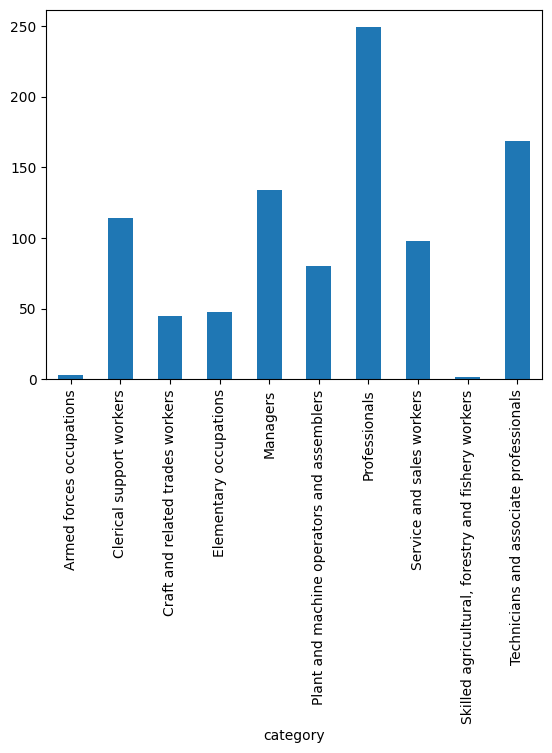

In [37]:
df.groupby(['category']).size().plot.bar()

In [38]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
labels = {'Armed forces occupations':0,
          'Clerical support workers':1,
          'Craft and related trades workers':2,
          'Elementary occupations':3,
          'Managers':4,
          'Plant and machine operators and assemblers':5,
          'Professionals':6,
          'Service and sales workers':7,
          'Skilled agricultural, forestry and fishery workers':8,
          'Technicians and associate professionals':9
          }

class Dataset(torch.utils.data.Dataset):

    def __init__(self, df):

        self.labels = [labels[label] for label in df['category']]
        self.texts = [tokenizer(text, 
                               padding='max_length', max_length = 512, truncation=True,
                                return_tensors="pt") for text in df['text']]

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]

    def __getitem__(self, idx):

        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_texts, batch_y

In [39]:
class BertClassifier(nn.Module):

    def __init__(self, dropout=0.5):

        super(BertClassifier, self).__init__()

        self.bert = BertModel.from_pretrained('bert-base-cased')
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(768, 10)
        self.relu = nn.ReLU()

    def forward(self, input_id, mask):

        _, pooled_output = self.bert(input_ids= input_id, attention_mask=mask,return_dict=False)
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
        final_layer = self.relu(linear_output)

        return final_layer

In [40]:
def train(model, train_data, val_data, learning_rate, epochs):

    train, val = Dataset(train_data), Dataset(val_data)

    train_dataloader = torch.utils.data.DataLoader(train, batch_size=2, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr= learning_rate)

    if use_cuda:

            model = model.cuda()
            criterion = criterion.cuda()

    for epoch_num in range(epochs):

            total_acc_train = 0
            total_loss_train = 0

            for train_input, train_label in tqdm(train_dataloader):

                train_label = train_label.to(device)
                mask = train_input['attention_mask'].to(device)
                input_id = train_input['input_ids'].squeeze(1).to(device)

                output = model(input_id, mask)
                
                batch_loss = criterion(output, train_label.long())
                total_loss_train += batch_loss.item()
                
                acc = (output.argmax(dim=1) == train_label).sum().item()
                total_acc_train += acc

                model.zero_grad()
                batch_loss.backward()
                optimizer.step()
            
            total_acc_val = 0
            total_loss_val = 0

            with torch.no_grad():

                for val_input, val_label in val_dataloader:

                    val_label = val_label.to(device)
                    mask = val_input['attention_mask'].to(device)
                    input_id = val_input['input_ids'].squeeze(1).to(device)

                    output = model(input_id, mask)

                    batch_loss = criterion(output, val_label.long())
                    total_loss_val += batch_loss.item()
                    
                    acc = (output.argmax(dim=1) == val_label).sum().item()
                    total_acc_val += acc
            
            print(
                f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(train_data): .3f} | Train Accuracy: {total_acc_train / len(train_data): .3f} | Val Loss: {total_loss_val / len(val_data): .3f} | Val Accuracy: {total_acc_val / len(val_data): .3f}')
                  

In [41]:
def evaluate(model, test_data):

    test = Dataset(test_data)

    test_dataloader = torch.utils.data.DataLoader(test, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:

        model = model.cuda()

    total_acc_test = 0
    with torch.no_grad():

        for test_input, test_label in test_dataloader:

              test_label = test_label.to(device)
              mask = test_input['attention_mask'].to(device)
              input_id = test_input['input_ids'].squeeze(1).to(device)

              output = model(input_id, mask)

              acc = (output.argmax(dim=1) == test_label).sum().item()
              total_acc_test += acc
    
    print(f'Test Accuracy: {total_acc_test / len(test_data): .3f}')

In [42]:
np.random.seed(112)
df_train, df_val, df_test = np.split(df.sample(frac=1, random_state=42), 
                                     [int(.8*len(df)), int(.9*len(df))])

print(len(df_train),len(df_val), len(df_test))

753 94 95


In [43]:
EPOCHS = 25
model = BertClassifier()
LR = 1e-6
              
train(model, df_train, df_val, LR, EPOCHS)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 377/377 [38:51<00:00,  6.19s/it]


Epochs: 1 | Train Loss:  1.176 | Train Accuracy:  0.113 | Val Loss:  1.132 | Val Accuracy:  0.160


100%|██████████| 377/377 [39:17<00:00,  6.25s/it]


Epochs: 2 | Train Loss:  1.105 | Train Accuracy:  0.189 | Val Loss:  1.083 | Val Accuracy:  0.223


100%|██████████| 377/377 [40:45<00:00,  6.49s/it]


Epochs: 3 | Train Loss:  1.049 | Train Accuracy:  0.242 | Val Loss:  1.082 | Val Accuracy:  0.234


100%|██████████| 377/377 [43:03<00:00,  6.85s/it]


Epochs: 4 | Train Loss:  1.021 | Train Accuracy:  0.264 | Val Loss:  1.070 | Val Accuracy:  0.234


100%|██████████| 377/377 [34:07<00:00,  5.43s/it]


Epochs: 5 | Train Loss:  0.980 | Train Accuracy:  0.279 | Val Loss:  1.048 | Val Accuracy:  0.191


100%|██████████| 377/377 [29:05<00:00,  4.63s/it]


Epochs: 6 | Train Loss:  0.945 | Train Accuracy:  0.317 | Val Loss:  1.032 | Val Accuracy:  0.234


100%|██████████| 377/377 [29:19<00:00,  4.67s/it]


Epochs: 7 | Train Loss:  0.893 | Train Accuracy:  0.361 | Val Loss:  1.012 | Val Accuracy:  0.266


100%|██████████| 377/377 [29:02<00:00,  4.62s/it]


Epochs: 8 | Train Loss:  0.846 | Train Accuracy:  0.417 | Val Loss:  1.047 | Val Accuracy:  0.223


100%|██████████| 377/377 [29:34<00:00,  4.71s/it]


Epochs: 9 | Train Loss:  0.820 | Train Accuracy:  0.469 | Val Loss:  0.998 | Val Accuracy:  0.266


100%|██████████| 377/377 [1:01:03<00:00,  9.72s/it]


Epochs: 10 | Train Loss:  0.772 | Train Accuracy:  0.493 | Val Loss:  0.998 | Val Accuracy:  0.245


100%|██████████| 377/377 [1:13:47<00:00, 11.74s/it]


Epochs: 11 | Train Loss:  0.734 | Train Accuracy:  0.538 | Val Loss:  1.014 | Val Accuracy:  0.223


100%|██████████| 377/377 [1:13:51<00:00, 11.75s/it]


Epochs: 12 | Train Loss:  0.691 | Train Accuracy:  0.564 | Val Loss:  0.999 | Val Accuracy:  0.277


100%|██████████| 377/377 [1:14:07<00:00, 11.80s/it]


Epochs: 13 | Train Loss:  0.657 | Train Accuracy:  0.604 | Val Loss:  1.016 | Val Accuracy:  0.277


100%|██████████| 377/377 [1:13:25<00:00, 11.69s/it]


Epochs: 14 | Train Loss:  0.612 | Train Accuracy:  0.643 | Val Loss:  1.000 | Val Accuracy:  0.298


100%|██████████| 377/377 [1:11:23<00:00, 11.36s/it]


Epochs: 15 | Train Loss:  0.585 | Train Accuracy:  0.672 | Val Loss:  1.038 | Val Accuracy:  0.266


100%|██████████| 377/377 [1:11:48<00:00, 11.43s/it]


Epochs: 16 | Train Loss:  0.545 | Train Accuracy:  0.692 | Val Loss:  0.983 | Val Accuracy:  0.319


100%|██████████| 377/377 [1:00:55<00:00,  9.70s/it]


Epochs: 17 | Train Loss:  0.515 | Train Accuracy:  0.726 | Val Loss:  0.995 | Val Accuracy:  0.319


100%|██████████| 377/377 [32:59<00:00,  5.25s/it]


Epochs: 18 | Train Loss:  0.487 | Train Accuracy:  0.750 | Val Loss:  1.014 | Val Accuracy:  0.330


100%|██████████| 377/377 [37:35<00:00,  5.98s/it]


Epochs: 19 | Train Loss:  0.454 | Train Accuracy:  0.760 | Val Loss:  1.043 | Val Accuracy:  0.277


100%|██████████| 377/377 [1:27:46<00:00, 13.97s/it]


Epochs: 20 | Train Loss:  0.425 | Train Accuracy:  0.778 | Val Loss:  1.040 | Val Accuracy:  0.287


100%|██████████| 377/377 [1:18:28<00:00, 12.49s/it]


Epochs: 21 | Train Loss:  0.412 | Train Accuracy:  0.777 | Val Loss:  1.021 | Val Accuracy:  0.351


100%|██████████| 377/377 [1:14:59<00:00, 11.94s/it]


Epochs: 22 | Train Loss:  0.382 | Train Accuracy:  0.788 | Val Loss:  1.028 | Val Accuracy:  0.340


100%|██████████| 377/377 [1:14:58<00:00, 11.93s/it]


Epochs: 23 | Train Loss:  0.363 | Train Accuracy:  0.797 | Val Loss:  1.087 | Val Accuracy:  0.309


100%|██████████| 377/377 [1:12:02<00:00, 11.47s/it]


Epochs: 24 | Train Loss:  0.343 | Train Accuracy:  0.811 | Val Loss:  1.069 | Val Accuracy:  0.330


100%|██████████| 377/377 [32:47<00:00,  5.22s/it] 


Epochs: 25 | Train Loss:  0.330 | Train Accuracy:  0.815 | Val Loss:  1.062 | Val Accuracy:  0.319


In [44]:
evaluate(model, df_test)

Test Accuracy:  0.305
